## Практическое задание к уроку 2 по теме "Feed-forward neural network".

### Задание 1.  
Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных).  
Варианты изменений:  
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

Импорт библиотек и загрузка данных:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
PATH = '../../Теория/Lesson_2/data/'

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root=PATH,
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=False)

test_dataset = torchvision.datasets.CIFAR10(root=PATH, train=False,
                                            download=False, transform=transforms.ToTensor())

In [4]:
torch.random.manual_seed(29)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset),
                                          shuffle=False)

In [5]:
with open(PATH + 'cifar-10-batches-py/batches.meta', 'rb') as f:
    classes = pickle.load(f)['label_names']

In [6]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Модификация модели нейронной сети с урока:

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.random.manual_seed(29)
        
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(4 * hidden_dim, hidden_dim)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        # self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        # torch.nn.init.xavier_uniform_(self.fc3.weight)
        
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        # x = self.fc3(x)
        # x = F.relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x, dim=1)
        return x

Обучение модели:

In [8]:
net = Net(32*32*3, 128, 10)
net.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# torch.manual_seed(29)
# hflipper = transforms.RandomHorizontalFlip(p=0.5)

EPOCHS = 5

for epoch in range(EPOCHS):

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        
        # for idx, image in enumerate(inputs):
        #     inputs[idx] = hflipper(image)
        
         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{EPOCHS}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss}')

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 2.40537166595459
Epoch [1/5]. Step [301/782]. Loss: 1.676841378211975
Epoch [1/5]. Step [601/782]. Loss: 1.795102834701538
Epoch [2/5]. Step [1/782]. Loss: 1.8891857862472534
Epoch [2/5]. Step [301/782]. Loss: 1.7397834062576294
Epoch [2/5]. Step [601/782]. Loss: 1.7740633487701416
Epoch [3/5]. Step [1/782]. Loss: 1.6319078207015991
Epoch [3/5]. Step [301/782]. Loss: 1.3760545253753662
Epoch [3/5]. Step [601/782]. Loss: 1.523927927017212
Epoch [4/5]. Step [1/782]. Loss: 1.3734452724456787
Epoch [4/5]. Step [301/782]. Loss: 1.4432224035263062
Epoch [4/5]. Step [601/782]. Loss: 1.6370434761047363
Epoch [5/5]. Step [1/782]. Loss: 1.5695897340774536
Epoch [5/5]. Step [301/782]. Loss: 1.6851153373718262
Epoch [5/5]. Step [601/782]. Loss: 1.3836666345596313
Training is finished!


Графическое представление результата:

In [9]:
def plot_image(prediction_array, true_label, img):

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.permute(1, 2, 0))

    predicted_label = torch.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% \n({})".format(classes[predicted_label],
                                100*torch.max(prediction_array),
                                classes[true_label]),
                                color=color)

In [10]:
def plot_value_array(prediction_array, true_label):

    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks([])
    plot = plt.bar(range(len(classes)), prediction_array.detach().numpy(), color="#777777")
    plt.ylim([0, 1])
    predicted_label = torch.argmax(prediction_array)

    plot[predicted_label].set_color('red')
    plot[true_label].set_color('blue')

Accuracy: 47.83 %


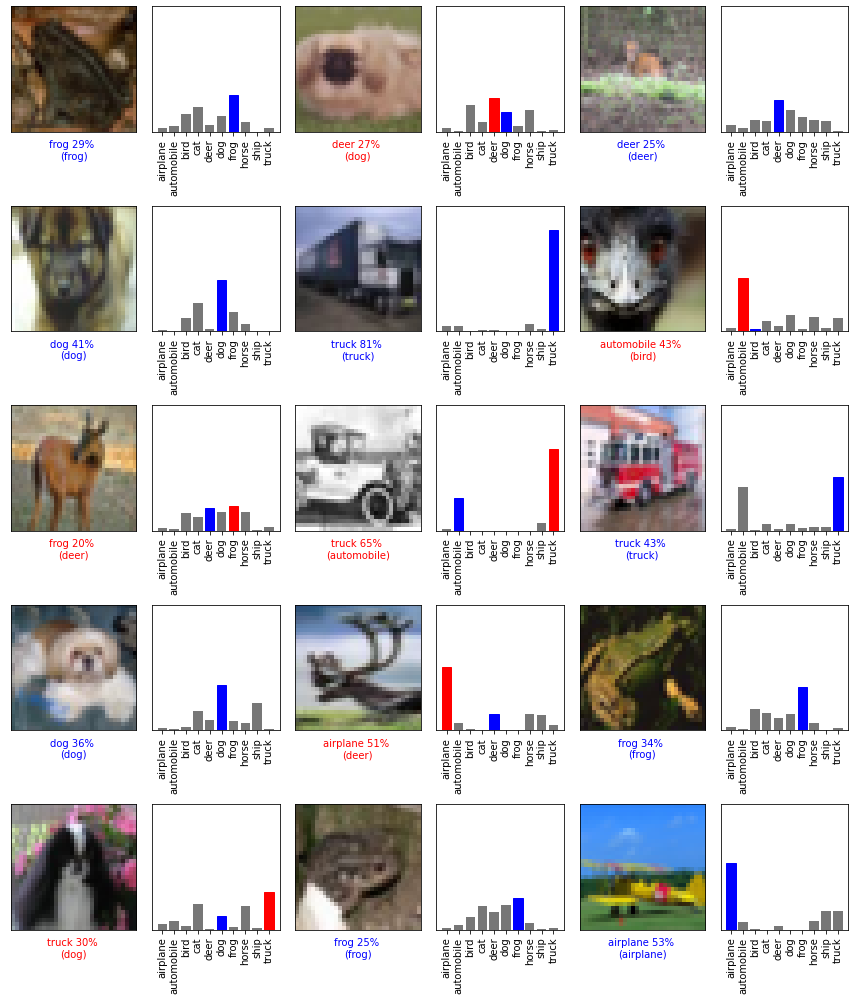

In [11]:
PAGE = 3

data_iter = iter(test_loader)
images, labels = data_iter.next()

net.eval()
predictions = net.predict(images)

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols

print(f'Accuracy: {(torch.argmax(predictions, axis=1) == labels).sum() / len(labels) * 100:.2f} %')
plt.figure(figsize=(2*2*num_cols, 2*1.4*num_rows))
for i in range(num_images):
    idx = i + (PAGE-1) * num_images
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[idx], labels[idx], images[idx])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[idx], labels[idx])
    
plt.tight_layout()
plt.show()

Выводы:

Для улучшения качества модели было сделано следующее:  
- убран третий скрытый слой;  
- заменены функции активации на ReLU;  
- заменён оптимизатор на Adam;  
- изменён способ инициализации весов.  
<br>

Что не помогло:  
- аугментация изображений (горизонтальное отзеркаливание);  
- добавление дропаута.

### Задание 2.

*Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru*

**Загрузите набор данных**

In [12]:
train_dataset = torchvision.datasets.MNIST(root=PATH,
                                           train=True,  
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=PATH, train=False,
                                          download=True, transform=transforms.ToTensor())

In [13]:
torch.random.manual_seed(29)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset),
                                          shuffle=False)

**Построить модель машинного обучения**

In [14]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        torch.random.manual_seed(29)
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2)
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x, dim=1)
        return x

**Обучите и оцените свою модель**

In [15]:
mnist_model = MnistNN()
mnist_model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters())

EPOCHS = 5

for epoch in range(EPOCHS):

    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]
        
         # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = mnist_model(inputs)
        # Рассчитываем лосс-функцию
        loss = criterion(outputs, labels)
        # Делаем шаг назад по лоссу
        loss.backward()
        # Делаем шаг нашего оптимайзера
        optimizer.step()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{EPOCHS}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss}')

print('Training is finished!')

Epoch [1/5]. Step [1/1875]. Loss: 2.3068771362304688
Epoch [1/5]. Step [301/1875]. Loss: 0.3681689202785492
Epoch [1/5]. Step [601/1875]. Loss: 0.3358961343765259
Epoch [1/5]. Step [901/1875]. Loss: 0.38957205414772034
Epoch [1/5]. Step [1201/1875]. Loss: 0.3339846432209015
Epoch [1/5]. Step [1501/1875]. Loss: 0.22602790594100952
Epoch [1/5]. Step [1801/1875]. Loss: 0.09469600766897202
Epoch [2/5]. Step [1/1875]. Loss: 0.0572441890835762
Epoch [2/5]. Step [301/1875]. Loss: 0.19747602939605713
Epoch [2/5]. Step [601/1875]. Loss: 0.1040787547826767
Epoch [2/5]. Step [901/1875]. Loss: 0.03807835653424263
Epoch [2/5]. Step [1201/1875]. Loss: 0.1283004879951477
Epoch [2/5]. Step [1501/1875]. Loss: 0.12285348027944565
Epoch [2/5]. Step [1801/1875]. Loss: 0.19524624943733215
Epoch [3/5]. Step [1/1875]. Loss: 0.049356862902641296
Epoch [3/5]. Step [301/1875]. Loss: 0.08956469595432281
Epoch [3/5]. Step [601/1875]. Loss: 0.23381386697292328
Epoch [3/5]. Step [901/1875]. Loss: 0.2030603289604187

In [16]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

In [17]:
mnist_model.eval()
predictions = mnist_model.predict(images)
predictions = torch.argmax(predictions, axis=1)
predictions

tensor([7, 2, 1,  ..., 4, 5, 6])

In [18]:
predictions.shape

torch.Size([10000])

In [19]:
print(f'Accuracy: {(predictions == labels).sum() / len(labels) * 100:.2f} %')

Accuracy: 97.26 %
